In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
%matplotlib inline

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/movielens-1m-dataset/users.dat
/kaggle/input/movielens-1m-dataset/ratings.dat
/kaggle/input/movielens-1m-dataset/README
/kaggle/input/movielens-1m-dataset/movies.dat


# **Recommender Systems Movie Recommendation**


In this project we are going to build six different recommender systems (sorted from basic to more complicated) for Movielens 1M dataset. The dataset contains about 1 million anonymous ratings of approximately 3,900 movies made by 6,040 MovieLens users who joined MovieLens in 2000. We then create an interactive web application for the user to choose their favorite movies and get recommendations. Below is a link to the web application:

[abishekjs.pythonanywhere.com](http:/abishekjs.pythonanywhere.com/)

Tasks Responsibilities:
* Abishek Samuel (asamuel4): Application Development
* Donia Zaheri (DoniaZ2): Recommender Systems Modeling

The first two recommender algorithms make recommendation based on genre. The last four algorithms make more personilzied recommendations by collaborative recommendation, asking the user to rate a number of movies and using that input to make the movies recommendation to the user.

In [3]:
from scipy import sparse
from lightfm import LightFM
from lightfm.evaluation import precision_at_k
from lightfm.evaluation import auc_score

from lightfm.datasets import fetch_movielens

movielens = fetch_movielens()

In [4]:
from tabulate import tabulate
from surprise import Dataset
from surprise import Reader
from surprise import BaselineOnly

import random
from pathlib import Path
import matplotlib.pyplot as plt
from collections import defaultdict

from surprise.model_selection import train_test_split

from surprise import KNNWithMeans  
from surprise import SVD 

from surprise.model_selection import GridSearchCV

from surprise import accuracy

Importing Movielens dataset into Pandas data frames

In [5]:
column_names = ['User_ID', 'MovieID', 'Rating', 'Timestamp']
ratings = pd.read_csv("../input/movielens-1m-dataset/ratings.dat", sep = "::", names = column_names, engine='python')
ratings.head()

,User_ID,MovieID,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [6]:
column_names = ['User_ID', 'Gender', 'Age', 'Occupation', 'Zip-code']
users = pd.read_csv("../input/movielens-1m-dataset/users.dat", sep = "::", names = column_names, engine='python')
users.head()

,User_ID,Gender,Age,Occupation,Zip-code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


In [7]:
column_names = ['MovieID', 'Title', 'Genres']
movies = pd.read_csv("../input/movielens-1m-dataset/movies.dat", sep = "::", names = column_names, encoding='latin-1', engine='python')
movies.head() 

,MovieID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


# Data Preparation and Analysis

Here we do basic data analysis, preparing the dataframes for our input type.

For system | recommendation we need to provide two algorithms to recommend top 10 movies in a genre selected by the user.
* Algorithm one implements "top" as the most viewed movies in that genre.
* Algorithm two implements "top" as the most popular movies in that genre. We later explain on the process for determining the most popular

Some movies have multiple gerne tags in the "Genres" columns. We need to split this column into different genres. 

In [8]:
movies[['Genre 1', 'Genre 2', 'Genre 3', 'Genre 4', 'Genre 5', 'Genre 6']] = movies.Genres.str.split("|",expand=True)
movies.head()

,MovieID,Title,Genres,Genre 1,Genre 2,Genre 3,Genre 4,Genre 5,Genre 6
0,1,Toy Story (1995),Animation|Children's|Comedy,Animation,Children's,Comedy,None,None,None
1,2,Jumanji (1995),Adventure|Children's|Fantasy,Adventure,Children's,Fantasy,None,None,None
2,3,Grumpier Old Men (1995),Comedy|Romance,Comedy,Romance,None,None,None,None
3,4,Waiting to Exhale (1995),Comedy|Drama,Comedy,Drama,None,None,None,None
4,5,Father of the Bride Part II (1995),Comedy,Comedy,None,None,None,None,None


Merging movies and ratings dataframes to have both the ratings and movies information in one data frame for analyzing

In [9]:
movieset = pd.merge(movies, ratings, on = 'MovieID')
movieset.head()

,MovieID,Title,Genres,Genre 1,Genre 2,Genre 3,Genre 4,Genre 5,Genre 6,User_ID,Rating,Timestamp
0,1,Toy Story (1995),Animation|Children's|Comedy,Animation,Children's,Comedy,None,None,None,1,5,978824268
1,1,Toy Story (1995),Animation|Children's|Comedy,Animation,Children's,Comedy,None,None,None,6,4,978237008
2,1,Toy Story (1995),Animation|Children's|Comedy,Animation,Children's,Comedy,None,None,None,8,4,978233496
3,1,Toy Story (1995),Animation|Children's|Comedy,Animation,Children's,Comedy,None,None,None,9,5,978225952
4,1,Toy Story (1995),Animation|Children's|Comedy,Animation,Children's,Comedy,None,None,None,10,5,978226474


# Data Exploratory

Belwo is some basic data exploratory steps to get more familiarize with the movielens 1 m dataset

Let's see what are the top five most rated movies

In [10]:
most_rated_movies = movieset.groupby('Title').size().sort_values(ascending = False)
most_rated_movies[:5]

Title
American Beauty (1999)                                   3428
Star Wars: Episode IV - A New Hope (1977)                2991
Star Wars: Episode V - The Empire Strikes Back (1980)    2990
Star Wars: Episode VI - Return of the Jedi (1983)        2883
Jurassic Park (1993)                                     2672
dtype: int64

And what are top 5 with highest ranking rates in the dataframe

In [11]:
popular_movies = movieset.groupby('Title')['Rating'].mean().sort_values(ascending = False)
popular_movies.head()

Title
Ulysses (Ulisse) (1954)     5.0
Lured (1947)                5.0
Follow the Bitch (1998)     5.0
Bittersweet Motel (2000)    5.0
Song of Freedom (1936)      5.0
Name: Rating, dtype: float64

The issue with the above approach is that although some movies might have a very highly ranked (5, 4 stars) rating, but might have not been watched with many users. These movies should not be listed as popular if only a small group of users have watched them.
Below we can see that this is actually the case and therefore the issue with just sorting the ratings in the datasset to get the most popular movies.

In [12]:
popular_movies_count = movieset.groupby('Title')['Rating'].count().sort_values(ascending = False)
popular_movies_count.head()

Title
American Beauty (1999)                                   3428
Star Wars: Episode IV - A New Hope (1977)                2991
Star Wars: Episode V - The Empire Strikes Back (1980)    2990
Star Wars: Episode VI - Return of the Jedi (1983)        2883
Jurassic Park (1993)                                     2672
Name: Rating, dtype: int64

To fix that issue, we add a column named "Number of Ratings" to get the number of ratings for each movie along with their average ranking

In [13]:
movie_ratings = pd.DataFrame(movieset.groupby('Title')['Rating'].mean())
movie_ratings['Number of Ratings'] = movieset.groupby('Title')['Rating'].count()
movie_ratings.head()

,Rating,Number of Ratings
Title,,
"$1,000,000 Duck (1971)",3.027027,37
'Night Mother (1986),3.371429,70
'Til There Was You (1997),2.692308,52
"'burbs, The (1989)",2.910891,303
...And Justice for All (1979),3.713568,199


# Data Visualization

Plotting number of ratings per movie

<AxesSubplot:>

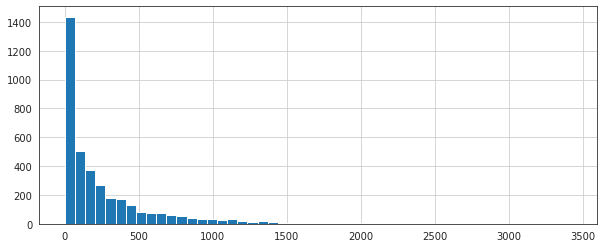

In [14]:
plt.figure(figsize = (10, 4))
movie_ratings['Number of Ratings'].hist(bins = 50)

Plotting ratings distribution

<AxesSubplot:>

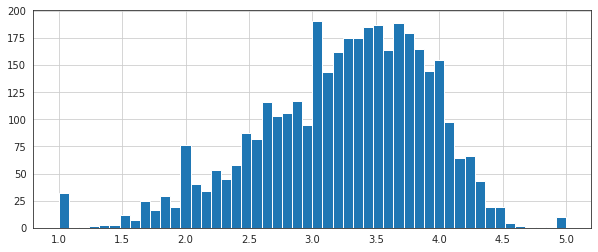

In [15]:
plt.figure(figsize = (10, 4))
movie_ratings['Rating'].hist(bins = 50)

# **Finding Top Movies Per Genre**

# System I The Most Rated Movies Per Genre

In this segment we will find the most rated movies in the given genre.

In [16]:
def topgenremovies(movieset, selectedgenre, Genre_1, Genre_2, Genre_3, Genre_4,
                    Genre_5, Genre_6, Title, Rating, Num_Ratings,min_num, top_n):
    moviegenre1 = movieset[movieset[Genre_1] == selectedgenre]
    moviegenre2 = movieset[movieset[Genre_1] == selectedgenre]
    moviegenre3 = movieset[movieset[Genre_1] == selectedgenre]
    moviegenre4 = movieset[movieset[Genre_1] == selectedgenre]
    moviegenre5 = movieset[movieset[Genre_1] == selectedgenre]
    moviegenre6 = movieset[movieset[Genre_1] == selectedgenre]
    moviegenre = pd.concat([moviegenre1, moviegenre2, moviegenre3, moviegenre4, moviegenre5, moviegenre6])
    movieonegenrerating = pd.DataFrame(moviegenre.groupby(Title)[Rating].mean())
    movieonegenrerating[Num_Ratings] = moviegenre.groupby(Title)[Rating].count()
    highlyrated_onegenre_movies = movieonegenrerating[movieonegenrerating[Num_Ratings] > min_num].sort_values(Num_Ratings, ascending = False).reset_index()
    top_movies = list(highlyrated_onegenre_movies[Title][0:top_n])
    
    return(top_movies)

In [17]:
genre_list = ["Action", "Adventure", "Animation", "Children's", "Comedy", "Crime", "Documentary", "Drama", "Film-Noir",
              "Horror", "Musical", "Mystery", "Romance", "Sci-Fi", "Thriller", "War", "Western"]

allgenres_top = pd.DataFrame(columns = genre_list)
allgenres_top.head()

for genre in allgenres_top.columns:
    allgenres_top[genre] = topgenremovies(movieset, genre, 'Genre 1', 'Genre 2', 'Genre 3', 'Genre 4', 'Genre 5', 'Genre 6',
                                          'Title', 'Rating', 'Number of Ratings',70, 10)
    
allgenres_top.head()

,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,Star Wars: Episode IV - A New Hope (1977),Who Framed Roger Rabbit? (1988),Toy Story (1995),E.T. the Extra-Terrestrial (1982),American Beauty (1999),Fargo (1996),Hoop Dreams (1994),"Silence of the Lambs, The (1991)",Blade Runner (1982),Psycho (1960),"Sound of Music, The (1965)",Rear Window (1954),Rebecca (1940),Dr. Strangelove or: How I Learned to Stop Worr...,"Sixth Sense, The (1999)",All Quiet on the Western Front (1930),Unforgiven (1992)
1,Star Wars: Episode V - The Empire Strikes Back...,Stand by Me (1986),"Bug's Life, A (1998)",Babe (1995),Back to the Future (1985),L.A. Confidential (1997),Crumb (1994),Schindler's List (1993),Chinatown (1974),"Blair Witch Project, The (1999)",West Side Story (1961),"X-Files: Fight the Future, The (1998)",City of Angels (1998),"Clockwork Orange, A (1971)",Fatal Attraction (1987),"Run Silent, Run Deep (1958)",Tombstone (1993)
2,Star Wars: Episode VI - Return of the Jedi (1983),Galaxy Quest (1999),Toy Story 2 (1999),Mary Poppins (1964),Shakespeare in Love (1998),Pulp Fiction (1994),American Movie (1999),"Shawshank Redemption, The (1994)","Maltese Falcon, The (1941)","Shining, The (1980)",Singin' in the Rain (1952),Vertigo (1958),Meet Joe Black (1998),Brazil (1985),Nikita (La Femme Nikita) (1990),Tora! Tora! Tora! (1970),High Noon (1952)
3,Jurassic Park (1993),"Wizard of Oz, The (1939)",Aladdin (1992),"Nightmare Before Christmas, The (1993)",Groundhog Day (1993),"Usual Suspects, The (1995)",When We Were Kings (1996),One Flew Over the Cuckoo's Nest (1975),Dark City (1998),"Fly, The (1986)",Dirty Dancing (1987),"Game, The (1997)","Affair to Remember, An (1957)",Mission to Mars (2000),Cape Fear (1991),Pork Chop Hill (1959),"Outlaw Josey Wales, The (1976)"
4,Saving Private Ryan (1998),Dances with Wolves (1990),Chicken Run (2000),"Muppet Movie, The (1979)",Being John Malkovich (1999),GoodFellas (1990),"Thin Blue Line, The (1988)",2001: A Space Odyssey (1968),"Manchurian Candidate, The (1962)",Sleepy Hollow (1999),My Fair Lady (1964),Basic Instinct (1992),Persuasion (1995),"Cell, The (2000)","Bone Collector, The (1999)",Cross of Iron (1977),For a Few Dollars More (1965)


In [18]:
allgenres_top.to_csv('allgenres_top.csv')

# System I - Algorithm II: Finding Popular Movies in Each Genre

Now we propose another approach for recommending top movies to users for each genre: Popular movies
We define popular as movies which have more than average rating score and more than 70 people have reviewed it.

In [19]:
def populargenre(movieset, selectedgenre, Genre_1, Genre_2, Genre_3, Genre_4,
                    Genre_5, Genre_6, Title, Rating, Num_Ratings, min_num, top_n):
    moviegenre1 = movieset[movieset[Genre_1] == selectedgenre]
    moviegenre2 = movieset[movieset[Genre_1] == selectedgenre]
    moviegenre3 = movieset[movieset[Genre_1] == selectedgenre]
    moviegenre4 = movieset[movieset[Genre_1] == selectedgenre]
    moviegenre5 = movieset[movieset[Genre_1] == selectedgenre]
    moviegenre6 = movieset[movieset[Genre_1] == selectedgenre]
    moviegenre = pd.concat([moviegenre1, moviegenre2, moviegenre3, moviegenre4, moviegenre5, moviegenre6])
    movieonegenrerating = pd.DataFrame(moviegenre.groupby(Title)[Rating].mean())
    movieonegenrerating[Num_Ratings] = moviegenre.groupby(Title)[Rating].count()
    highlyrated_onegenre_movies = movieonegenrerating[movieonegenrerating[Num_Ratings] > min_num].sort_values(Rating, ascending = False).reset_index()
    top_movies = list(highlyrated_onegenre_movies[Title][0:top_n])
    
    return(top_movies)

In [20]:
genre_list = ["Action", "Adventure", "Animation", "Children's", "Comedy", "Crime", "Documentary", "Drama", "Film-Noir",
              "Horror", "Musical", "Mystery", "Romance", "Sci-Fi", "Thriller", "War", "Western"]

allgenres_popular = pd.DataFrame(columns = genre_list)
allgenres_popular.head()

for genre in allgenres_popular.columns:
    allgenres_popular[genre] = populargenre(movieset, genre, 'Genre 1', 'Genre 2', 'Genre 3', 'Genre 4', 'Genre 5', 'Genre 6',
                                          'Title', 'Rating', 'Number of Ratings',70, 10)
    
allgenres_popular.head()

,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,Sanjuro (1962),Lawrence of Arabia (1962),"Close Shave, A (1995)",E.T. the Extra-Terrestrial (1982),Yojimbo (1961),"Usual Suspects, The (1995)",For All Mankind (1989),"Shawshank Redemption, The (1994)",Sunset Blvd. (a.k.a. Sunset Boulevard) (1950),Psycho (1960),Singin' in the Rain (1952),Rear Window (1954),Rebecca (1940),Dr. Strangelove or: How I Learned to Stop Worr...,"Sixth Sense, The (1999)",All Quiet on the Western Front (1930),High Noon (1952)
1,Seven Samurai (The Magnificent Seven) (Shichin...,"Great Escape, The (1963)","Wrong Trousers, The (1993)",Mary Poppins (1964),City Lights (1931),Double Indemnity (1944),Jupiter's Wife (1994),Schindler's List (1993),"Maltese Falcon, The (1941)","Shining, The (1980)",My Fair Lady (1964),"Third Man, The (1949)",Persuasion (1995),Brazil (1985),Seven Days in May (1964),Land and Freedom (Tierra y libertad) (1995),Unforgiven (1992)
2,"Godfather, The (1972)",Dersu Uzala (1974),Wallace & Gromit: The Best of Aardman Animatio...,Babe (1995),"General, The (1927)",M (1931),When We Were Kings (1996),Paths of Glory (1957),Chinatown (1974),"Nosferatu (Nosferatu, eine Symphonie des Graue...",West Side Story (1961),Vertigo (1958),"Affair to Remember, An (1957)",Metropolis (1926),"39 Steps, The (1935)","Run Silent, Run Deep (1958)","Wild Bunch, The (1969)"
3,Raiders of the Lost Ark (1981),"Treasure of the Sierra Madre, The (1948)","Grand Day Out, A (1992)","Little Princess, A (1995)",Monty Python and the Holy Grail (1974),Pulp Fiction (1994),"Decline of Western Civilization, The (1981)",To Kill a Mockingbird (1962),"Manchurian Candidate, The (1962)",Frankenstein (1931),"King and I, The (1956)","Thin Man, The (1934)","Autumn Tale, An (Conte d'automne) (1998)","Clockwork Orange, A (1971)","Spiral Staircase, The (1946)",Prisoner of the Mountains (Kavkazsky Plennik) ...,"Searchers, The (1956)"
4,Star Wars: Episode IV - A New Hope (1977),"Wizard of Oz, The (1939)",Creature Comforts (1990),"Muppet Movie, The (1979)",Life Is Beautiful (La Vita è bella) (1997),GoodFellas (1990),"Wonderful, Horrible Life of Leni Riefenstahl, ...",Casablanca (1942),"Big Sleep, The (1946)","Exorcist, The (1973)",On the Town (1949),Gaslight (1944),Trick (1999),Forbidden Planet (1956),Three Days of the Condor (1975),Cross of Iron (1977),"Outlaw Josey Wales, The (1976)"


# ****Personalized Movie Recommendation****

In the second part, we will implement 4 different algorithms to make more personalized movie recommendations to user with both item-based and user-based recommendations.
We start with a very simple algorithm and make the algorithms more complicated for each model.

# 1. Movie Recommendation With Correlation Matrix

In this part, we first create a sparse matrix of each user and their rating for each movie. Then will find their correlation matrix with pearson correlation and use that to recommend movies to other users. This model will find the most similar movies to the given movie

In [21]:
def interactionmatrix(dataset, User_ID, Title, Rating):
    movie_user_interact = dataset.pivot_table(index = User_ID, columns = Title, values = Rating).fillna(0)
    return movie_user_interact

In [22]:
movie_user = interactionmatrix(movieset, 'User_ID', 'Title', 'Rating')
movie_user.head()

Title,"$1,000,000 Duck (1971)",'Night Mother (1986),'Til There Was You (1997),"'burbs, The (1989)",...And Justice for All (1979),1-900 (1994),10 Things I Hate About You (1999),101 Dalmatians (1961),101 Dalmatians (1996),12 Angry Men (1957),...,"Young Poisoner's Handbook, The (1995)",Young Sherlock Holmes (1985),Young and Innocent (1937),Your Friends and Neighbors (1998),Zachariah (1971),"Zed & Two Noughts, A (1985)",Zero Effect (1998),Zero Kelvin (Kjærlighetens kjøtere) (1995),Zeus and Roxanne (1997),eXistenZ (1999)
User_ID,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
def similarmovierecom(movie_user_interact, movie, Title, Num_Ratings, n):
    selectedmovie_user_rating = movie_user_interact[movie]
    selectedmovie_corr = movie_user.corrwith(selectedmovie_user_rating)
    selectedmovie_corr = pd.DataFrame(selectedmovie_corr, columns = ['Correlation'])
    selectedmovie_corr.dropna(inplace = True)
    selectedmovie_corr = selectedmovie_corr.join(movie_ratings[Num_Ratings])
    selectedmovie_corr_higlyrated = selectedmovie_corr[selectedmovie_corr[Num_Ratings] > 70].sort_values('Correlation', ascending = False).reset_index()
    top_movies = list(selectedmovie_corr_higlyrated[Title][1:n])
    
    return(top_movies)

In [24]:
americanbeauty_similar = similarmovierecom(movie_user, 'American Beauty (1999)', 'Title', 'Number of Ratings', 10)
print(americanbeauty_similar)

['Being John Malkovich (1999)', 'Election (1999)', 'Pulp Fiction (1994)', 'Fight Club (1999)', 'Clerks (1994)', 'Magnolia (1999)', 'Fargo (1996)', 'Rushmore (1998)', 'Boogie Nights (1997)']


# ****System II - Collaborative Recommendation Systems****

Here we will implement two collaborative models: KNN (memory based) and SVD (model based)

# 2. Movie Recommendation With Building a KNN Model

The first model is derived from a basic nearest neighbors approach. The model predicts ratings of user-item combination based on its neighborhood. Neighborhoods can be defined either as user based or item based.

Surprise library is used for KNN modeling. To find the best similarity measures parameters (sim_options) GridSearchCV with 5 - fold was used. GridsearchCV finds the best combination of sim_options that optimizes the accuracy metrics with cross-validation.
The model and the chosen parameters are explained in more details further.


In this step, the new user's ratings of 5 movies will be given to the code as input. (This is an interactive step in the developed app, here I have generated a fake input to be able to use user's input in the remaining parts of the code).

In [25]:
surprisedata = ratings.drop('Timestamp', axis = 1)
surprisedata = surprisedata.rename({'User_ID': 'userID', 'MovieID': 'itemID', 'Rating': 'rating'}, axis=1)

In [26]:
newuser = {'userID': np.repeat((surprisedata.shape[0] + 1), 5), 'itemID': [1, 4, 6, 3950, 3951], 'rating': [2, 3, 5, 5, 4]}
newuser = pd.DataFrame(data = newuser)
newuser.head()

,userID,itemID,rating
0,1000210,1,2
1,1000210,4,3
2,1000210,6,5
3,1000210,3950,5
4,1000210,3951,4


Surprise library gets a specific data format as an input. The input dataset for Surprise models must have three columns named "userID", "itemID", "rating". In the following parts the new user is added to the dataset and the dataset is prepared for Surprise KNN model input format. 

In [27]:
surprisedata = pd.concat([surprisedata, newuser], axis = 0).reset_index()

surprisedata.tail(10)

,index,userID,itemID,rating
1000204,1000204,6040,1091,1
1000205,1000205,6040,1094,5
1000206,1000206,6040,562,5
1000207,1000207,6040,1096,4
1000208,1000208,6040,1097,4
1000209,0,1000210,1,2
1000210,1,1000210,4,3
1000211,2,1000210,6,5
1000212,3,1000210,3950,5
1000213,4,1000210,3951,4


* KNNWithMeans is a KNN model that takes the mean rating of each user into account. This will solve the issue of the missing values in the ratings by not associating zero for missing values with a zero rating. Bascially centering the average of the user's rating at zero.
* Normalizing the rating matrix will solve the issue of the tough/easy rater. Some users are pickier when rating and will give thougher ratings in general and some other users give more generous ratings to all movies. KNNwithMeans algorithm normalizes the data by default.
* The data is divided into training (80%) and test(20%).
* Parameters for the model are selected with Gridsearch CV. Tuned sim_options parameters are:
    *   'K': The (max) number of neighbors to take into account for aggregation (see this note). Default: 40. Note: The actual number of neighbors that are aggregated to compute an estimation is necessarily less than or equal to k. First, there might just not exist enough neighbors and second the algorithm only includes neighbors for which the similarity measure is positive. It would make no sense to aggregate ratings from users (or items) that are negatively correlated.
    *   'name': The name of the similarity to use. Cosine similarity is used here.
    *   'min_support': The minimum number of common items (when 'user_based' is 'True') or minimum number of common users (when 'user_based' is 'False') for the similarity not to be zero.
    *   'user_based': Whether similarities will be computed between users or between items. This has a huge impact on the performance of a prediction algorithm.

In [28]:
train=surprisedata.iloc[:int(surprisedata.shape[0]*0.80)]
test=surprisedata.iloc[int(surprisedata.shape[0]*0.80):]
reader = Reader(rating_scale = (1,5))

full_data = Dataset.load_from_df(surprisedata[['userID', 'itemID', 'rating']], reader)
fulldata = full_data.build_full_trainset()
train_set = Dataset.load_from_df(train[['userID', 'itemID', 'rating']], reader)
trainset = train_set.build_full_trainset()

test_set = Dataset.load_from_df(test[['userID', 'itemID', 'rating']], reader)
testset = test_set.build_full_trainset()

In [29]:
sim_options = { "name": ["cosine"], "min_support": [3, 4, 5], "user_based": [False, True]}

param_grid = {"sim_options": sim_options}

knnmean_gridsearch = GridSearchCV(KNNWithMeans, param_grid, measures=["rmse", "mae"], cv=5)
knnmean_gridsearch.fit(full_data)

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing th

In [30]:
print(knnmean_gridsearch.best_score["rmse"])
print(knnmean_gridsearch.best_params["rmse"])

0.8896447047178402
{'sim_options': {'name': 'cosine', 'min_support': 5, 'user_based': False}}


Running KNNWithMeans model over 10 iterations

In [31]:
knn_rmses = {}
for i in range(10):
    knnmean = KNNWithMeans(n_epochs = i+1, sim_options={'name': 'cosine', 'min_support': 5, 'user_based': False})
    knnmean.fit(trainset)
    predictions = knnmean.test(testset.build_testset())
    knn_rmses[i+1] = accuracy.rmse(predictions)

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.1149
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.1149
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.1149
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.1149
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.1149
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.1149
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.1149
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.1149
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.1149
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.1149


Printing RMSE results for each iteration

In [32]:
print("Iterations", "RMSE")
for iterations, rmse in knn_rmses.items():
    print('{} {}'.format(iterations, rmse))

Iterations RMSE
1 1.1148566740752948
2 1.1148566740752948
3 1.1148566740752948
4 1.1148566740752948
5 1.1148566740752948
6 1.1148566740752948
7 1.1148566740752948
8 1.1148566740752948
9 1.1148566740752948
10 1.1148566740752948


# 3. Movie Recommendation With Building a SVD Model

Another approach for recommender systems is model based. Model based approach uses matrix factorization for the user-item interactions matrix. It transforms user-item matrix into a low-dimensional representation in terms of latent factors. These latent factors provide hidden characteristics about users and items. A user’s interaction with an item is modelled as the product of their latent vectors. Singular Vector Decomposition (SVD) is a popular matrix factorization algorithm.  The prediction r^ui is set as: r^ui=μ+bu+bi+qiTpu

The objective for this algorithm is to minimize the the regularized squared error here: ∑(rui−r^ui)^2 + λ(bi^2+bu^+||qi||^2+||pu||^2)    (rui∈Rtrain)

The algoithm improves its objective (minimizing the regularized squared error) with the stochastic gradient descent. GridSearchCV is used to find the best combination of the learning rate and the regularization term.
* "lr_all": The learning rate for all parameters.
* "reg_all": The regularization term for all parameters




In [33]:
param_grid = {"lr_all": [0.001, 0.003, 0.005], "reg_all": [0.2, 0.5, 0.7]}

svd_gridsearch = GridSearchCV(SVD, param_grid, measures=["rmse"], cv=5)
svd_gridsearch.fit(full_data)

print(svd_gridsearch.best_params["rmse"])

{'lr_all': 0.003, 'reg_all': 0.2}


In [34]:
print(svd_gridsearch.best_score["rmse"])
print(svd_gridsearch.best_params["rmse"])

0.9153940878057126
{'lr_all': 0.003, 'reg_all': 0.2}


In [35]:
svd_rmses = {}
for i in range(10):
    svd_alg = SVD(n_epochs = i+1, lr_all = 0.003, reg_all = 0.2)
    svd_alg.fit(trainset)
    predictions = svd_alg.test(testset.build_testset())
    svd_rmses[i+1] = accuracy.rmse(predictions)

RMSE: 1.0207
RMSE: 1.0079
RMSE: 1.0024
RMSE: 0.9992
RMSE: 0.9971
RMSE: 0.9956
RMSE: 0.9945
RMSE: 0.9937
RMSE: 0.9931
RMSE: 0.9926


In [36]:
print("Iterations", "RMSE")
for iterations, rmse in svd_rmses.items():
    print('{} {}'.format(iterations, rmse))

Iterations RMSE
1 1.020742386085276
2 1.0079272197763105
3 1.0023645170028526
4 0.9991628459151839
5 0.9970719080708272
6 0.9955999755304568
7 0.9945235174151463
8 0.9937163152554602
9 0.9930712870014013
10 0.9925712124475728


Finding Top n recommendations (that are not already in the training set) for the users 

In [37]:
def get_top_n(predictions, n=10):
    """Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    """

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n


In [38]:
svd_alg.fit(fulldata)

# Predict ratings for all pairs (u, i) that are NOT in the training set.
testset_full = fulldata.build_anti_testset()
predictions = svd_alg.test(testset_full)

top_n = get_top_n(predictions, n=10)


The code below prints top 10 movie recommendations for all users. This part has been commented due to the length of the output.

In [39]:
# Print the recommended items for each user
# for uid, user_ratings in top_n{1}.items():
#     print(uid, [iid for (iid, _) in user_ratings])

# **4. Building a Recommender System with LightFM**

LightFM is another library like Surprise with implemented algorithms for recommender systems. LightFM incorporates both item and user metadata into the traditional matrix factorization algorithms, making it possible to generalize to new items (via item features) and new users (via user features). LightFM is less computational heavy compared to Surprise models as surprise models need to go through each pair of user and item in a for loop to make predictions for top n recommendations to users, while LightFM can make this prediction in one line getting the array of the items as the input.

So, we also implemented a model with LightFM to make predictions as it is much faster than Surprise top_n prediction model and a better option to use for the application building.

Below we get input from the "New User" that has ranked n movies

In [40]:
newuserlikes = pd.DataFrame(np.array([[2, 3, 5, 5, 4]]).astype(int),
                   columns=["$1,000,000 Duck (1971)", "'Night Mother (1986)", "All the King's Men (1949)",
                           "Heaven & Earth (1993)", "Young Sherlock Holmes (1985)" ])

newuserlikes = pd.DataFrame(data = newuserlikes)

In [41]:
movie_user = movie_user.append(pd.Series(name= (movie_user.shape[0] + 1))).fillna(0)
movie_user.tail()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """Entry point for launching an IPython kernel.


,"$1,000,000 Duck (1971)",'Night Mother (1986),'Til There Was You (1997),"'burbs, The (1989)",...And Justice for All (1979),1-900 (1994),10 Things I Hate About You (1999),101 Dalmatians (1961),101 Dalmatians (1996),12 Angry Men (1957),...,"Young Poisoner's Handbook, The (1995)",Young Sherlock Holmes (1985),Young and Innocent (1937),Your Friends and Neighbors (1998),Zachariah (1971),"Zed & Two Noughts, A (1985)",Zero Effect (1998),Zero Kelvin (Kjærlighetens kjøtere) (1995),Zeus and Roxanne (1997),eXistenZ (1999)
User_ID,,,,,,,,,,,,,,,,,,,,,
6037,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6038,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6039,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6040,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6041,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [42]:
new_user_index = movie_user.shape[0]

for movie in newuserlikes.columns:
    movie_user.at[new_user_index,movie] = newuserlikes.iloc[0][movie]

movie_user.tail()

,"$1,000,000 Duck (1971)",'Night Mother (1986),'Til There Was You (1997),"'burbs, The (1989)",...And Justice for All (1979),1-900 (1994),10 Things I Hate About You (1999),101 Dalmatians (1961),101 Dalmatians (1996),12 Angry Men (1957),...,"Young Poisoner's Handbook, The (1995)",Young Sherlock Holmes (1985),Young and Innocent (1937),Your Friends and Neighbors (1998),Zachariah (1971),"Zed & Two Noughts, A (1985)",Zero Effect (1998),Zero Kelvin (Kjærlighetens kjøtere) (1995),Zeus and Roxanne (1997),eXistenZ (1999)
User_ID,,,,,,,,,,,,,,,,,,,,,
6037,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6038,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6039,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6040,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6041,2.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [43]:
lfdata = sparse.csr_matrix(movie_user.values)
lfmodel = LightFM(no_components = 30, loss = 'warp', k = 15)
lfmodel.fit(lfdata, epochs = 10)

Below we make recommendations to the user based on their the movies they have rated in the input

In [44]:
def sample_recommendation_user(model, interactions, user_id,
                               threshold = 0,nrec_items = 10, show = True):
    '''
    Function to produce user recommendations
    Required Input - 
        - model = Trained matrix factorization model
        - interactions = dataset used for training the model
        - user_id = user ID for which we need to generate recommendation
        - user_dict = Dictionary type input containing interaction_index as key and user_id as value
        - item_dict = Dictionary type input containing item_id as key and item_name as value
        - threshold = value above which the rating is favorable in new interaction matrix
        - nrec_items = Number of output recommendation needed
    Expected Output - 
        - Prints list of items the given user has already bought
        - Prints list of N recommended items  which user hopefully will be interested in
    '''
    n_users, n_items = interactions.shape
    scores = pd.Series(model.predict(user_id,np.arange(n_items)))
    scores.index = interactions.columns
    scores = list(pd.Series(scores.sort_values(ascending=False).index))
    
    known_items = list(pd.Series(interactions.loc[user_id,:] \
                                 [interactions.loc[user_id,:] > threshold].index) \
								 .sort_values(ascending=False))
    
    scores = [x for x in scores if x not in known_items]
    return_score_list = scores[0:nrec_items]
    scores = list(pd.Series(return_score_list))
    if show == True:
        print("\n Recommended Movies:")
        counter = 1
        for i in scores:
            print(counter,' ',i)
            counter+=1
    return return_score_list

In [45]:
recommended_movies =sample_recommendation_user(model = lfmodel, interactions = movie_user, user_id = 6040,
                               threshold = 0,nrec_items = 10, show = True)


 Recommended Movies:
1   It Happened One Night (1934)
2   Born Yesterday (1950)
3   Double Indemnity (1944)
4   His Girl Friday (1940)
5   Laura (1944)
6   Top Hat (1935)
7   All About Eve (1950)
8   Lady Vanishes, The (1938)
9   Shadow of a Doubt (1943)
10   Apartment, The (1960)


# References for this code:
A few parts of this code were used/modified from the resources below:
* https://surprise.readthedocs.io/en/stable/getting_started.html
* https://github.com/aayushmnit/cookbook
